## some new decoding analyses... 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns

In [2]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mouse_colors_2 = {409828: "#66CCEE", 416296: "#228833", 427836: '#CCBB44', 438833: '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = [409828, 416296, 427836, 438833]
mouse_mapping = {
    '409828': 'Mouse 1',
    '416296': 'Mouse 2',
    '427836': 'Mouse 3',
    '438833': 'Mouse 4'
}

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images",
    "natural_images_12", 
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images": "image_index",
    "natural_images_12": "image_index",
               }

multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images": "natural_images_12",
        "natural_images_12": "natural_images",
    }

chance = {
    "drifting_gratings_full": 1/12, 
    "drifting_gratings_windowed": 1/12, 
    "natural_images": 1/118,
    "natural_images_12": 1/12,
    }

def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

### 1. if the same subset of images in NS1 can be decoded if train/test is just NS1

### 2. if the first 20% of trials in NS2 is decodable

In [3]:
tag = "2025-09-17_7"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
stim_types = ["natural_images", "natural_images_12"]

for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])

    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

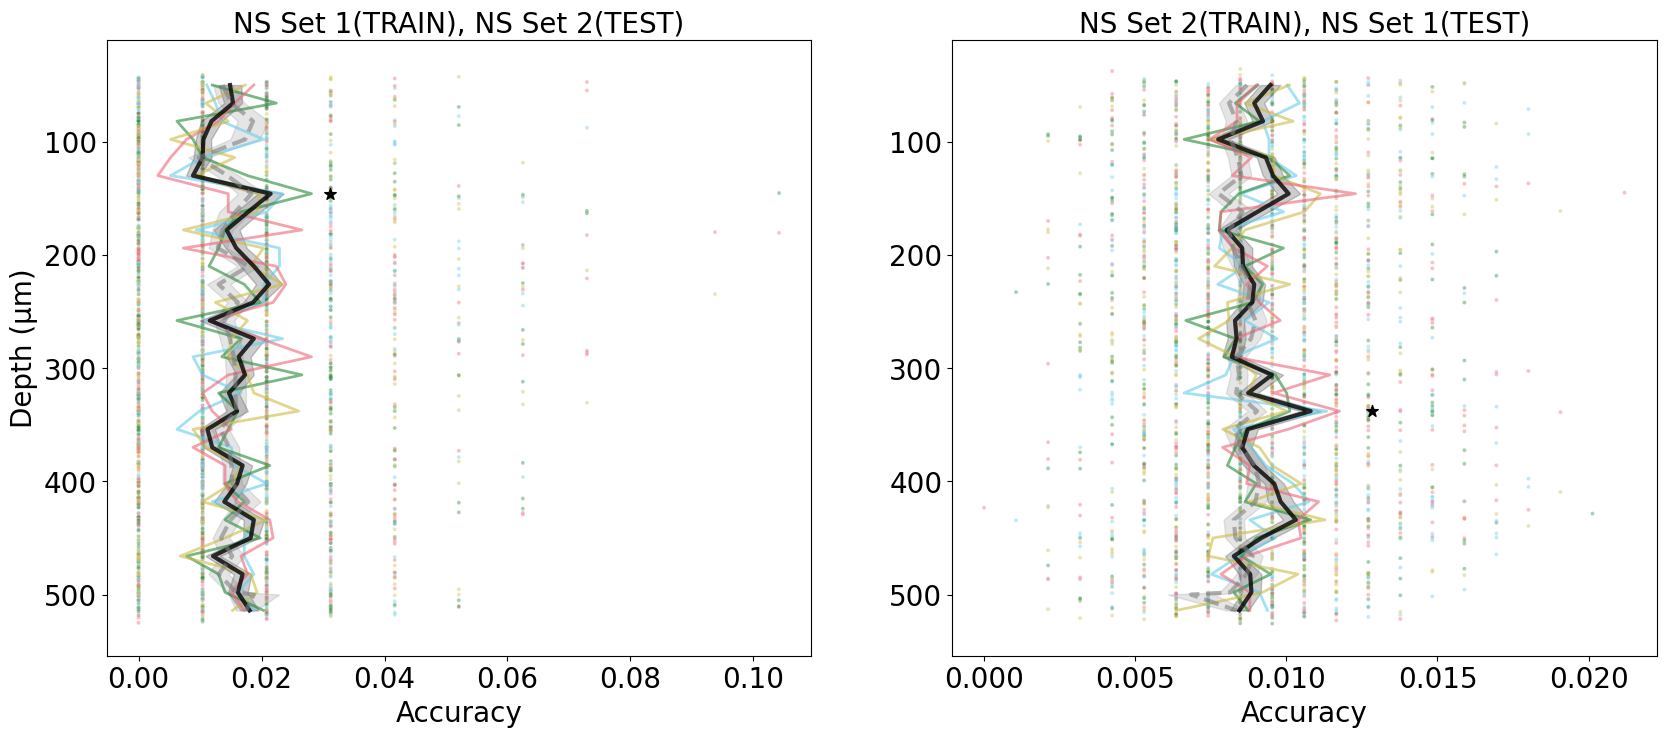

In [4]:
#### Plotting decoding accuracies for each mouse

# Some parameters for the plot
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}

n_stims = 2
jitter_amount = 5

fig, ax = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plotting individual mouse lines
    temp_df = all_results_df[(all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500) & (all_results_df['stim_type_training'] == stim_type)]
    temp_df = temp_df.explode('test_accuracy')
    stim_type_testing = multi_stim_pairs[stim_type]

    sns.lineplot(
        data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False,
    )

    sns.lineplot(data=temp_df, 
        x='test_accuracy', 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['test_accuracy'].mean().reset_index()
    sub_array = sub_df['test_accuracy'].values
    ax.scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)

    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        s=8,
        alpha=0.4,
        ax=ax,
        legend=False,
        zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_test_accuracy')
    # temp_df_shuf['shuf_test_accuracy'] = temp_df_shuf['shuf_test_accuracy'] / chance[stim_type]

    sns.lineplot(data=temp_df_shuf, 
        x='shuf_test_accuracy', 
        y='depth', 
        color='grey', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linestyle='--',
        linewidth=3, 
        alpha=0.6, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    ax.set_title(f"{titles[stim_type]}(TRAIN), {titles[stim_type_testing]}(TEST)", fontsize=fontsize)
    # ax.set_title(f"{titles[stim_type]}", fontsize=fontsize)
    ax.set_xlabel('Accuracy', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    # ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    # ax.set_xlim(left=0, right=0.8) if stim_idx != 2 else ax.set_xlim(left=0, right=0.25)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

# plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2D_nobootstrapping_1plane_valaccuracies_decoding.svg'), dpi=300)

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns

import sys, os
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import run_decoding
from allen_v1dd.client import OPhysClient
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from v1dd_public import ARTIFACT_DIR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [7]:
# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '23'
plane = 1
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

# Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
x_data = run_decoding.get_X_data(session, plane, "natural_images") # T x N
y_data = run_decoding.get_Y_data(session, plane, "natural_images", "image_index") # T x 1
x_data_other = run_decoding.get_X_data(session, plane, "natural_images_12") # T x N
y_data_other = run_decoding.get_Y_data(session, plane, "natural_images_12", "image_index") # T x 1

subset_test_data = False
if subset_test_data:
    y_data_other = y_data_other[:int(len(y_data_other) * 0.2)]
    x_data_other = x_data_other[:int(len(x_data_other) * 0.2), :]

match = True
if match:
    x_data = x_data[np.isin(y_data, y_data_other), :]
    y_data = y_data[np.isin(y_data, y_data_other)]

# Split the data into training and testing sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Perform k-NN classification with hyperparameter tuning
# param_grid = {'n_neighbors': list(range(1, 30))}
# knn = KNeighborsClassifier(metric='correlation')
# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(x_train, y_train)
# best_k_HIGH = grid_search.best_params_['n_neighbors']
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga']}
model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
model = LogisticRegression(**best_params, max_iter=1000)
model.fit(x_train, y_train)

# Fit the best model
# knn = KNeighborsClassifier(n_neighbors=best_k_HIGH, metric='correlation')
# knn.fit(x_train, y_train)

# Predict on training and validation data
y_pred_train = model.predict(x_train)
y_pred_val = model.predict(x_val)
y_pred_test = model.predict(x_data_other)

# Calculate accuracy
print(f"Subsetting test data to 20%: {subset_test_data}")
print(f"Matching train and test stimulus labels: {match}")
print(f"Training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")
print(f"Validation accuracy: {metrics.accuracy_score(y_val, y_pred_val) * 12}")
print(f"Test accuracy: {metrics.accuracy_score(y_data_other, y_pred_test) * 12}")

/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Subsetting test data to 20%: False
Matching train and test stimulus labels: True
Training accuracy: 1.0
Validation accuracy: 1.7999999999999998
Test accuracy: 0.9750000000000001


In [65]:
# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '21'
plane = 4
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

# Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
x_data = run_decoding.get_X_data(session, plane, "natural_images_12") # T x N
y_data = run_decoding.get_Y_data(session, plane, "natural_images_12", "image_index") # T x 1
# x_data_other = run_decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
# y_data_other = run_decoding.get_Y_data(session, plane, "drifting_gratings_windowed", "direction") # T x 1

match = False
if match:
    x_data = x_data[np.isin(y_data, y_data_other), :]
    y_data = y_data[np.isin(y_data, y_data_other)]

In [66]:
corrs = np.zeros((x_data.shape[0], x_data.shape[0]))
sorted_x_data = x_data[np.argsort(y_data), :]
sorted_y_data = y_data[np.argsort(y_data)]

for i in range(x_data.shape[0]):
    for j in range(x_data.shape[0]):
        if i == j:
            corrs[i, j] = 0
        else:
            corrs[i, j] = np.corrcoef(sorted_x_data[i, :], sorted_x_data[j, :])[0, 1]

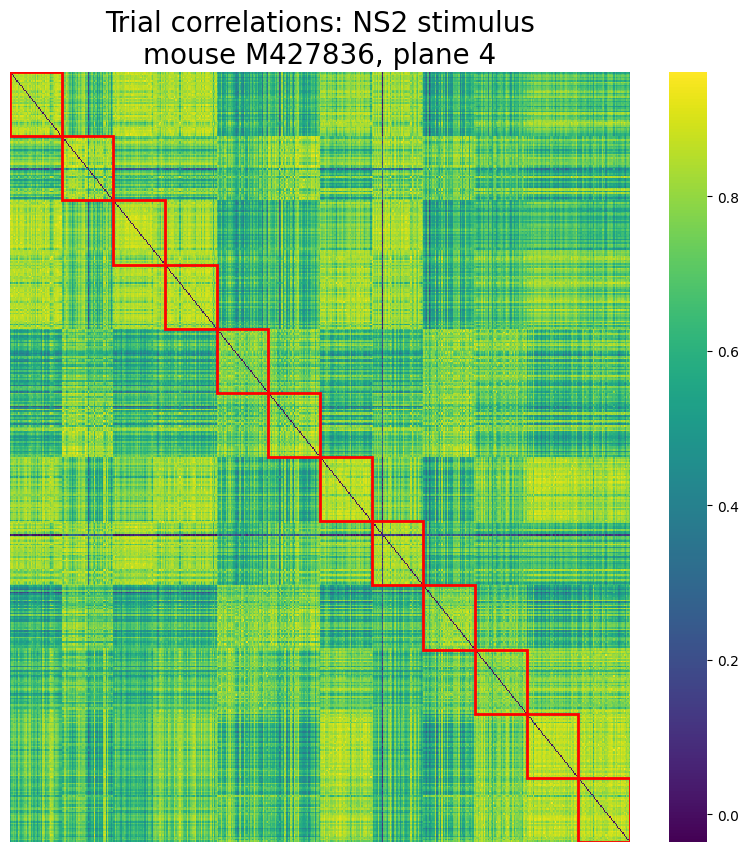

In [74]:
plt.figure(figsize=(10, 10))
sns.heatmap(corrs, cmap='viridis')
plt.title(f"Trial correlations: NS2 stimulus\nmouse {mouse_id}, plane {plane}", fontsize=20)
# plt.xticks(np.arange(0.5, len(sorted_y_data) + 0.5, 1), labels=sorted_y_data, rotation=90)
# plt.yticks(np.arange(0.5, len(sorted_y_data) + 0.5, 1), labels=sorted_y_data, rotation=0);
plt.xticks([])
plt.yticks([]);

# draw box around the trials where stimulus identites are the same
for i in np.unique(sorted_y_data):
    indices = np.where(sorted_y_data == i)[0]
    plt.gca().add_patch(plt.Rectangle((indices[0], indices[0]), len(indices), len(indices), fill=False, edgecolor='red', lw=2))

In [174]:
client.get_all_session_ids()

['M409828_11',
 'M409828_12',
 'M409828_13',
 'M409828_14',
 'M409828_15',
 'M409828_16',
 'M409828_17',
 'M409828_18',
 'M409828_19',
 'M409828_1a',
 'M409828_1b',
 'M409828_1c',
 'M409828_1d',
 'M409828_1e',
 'M409828_1f',
 'M409828_21',
 'M409828_22',
 'M409828_23',
 'M409828_24',
 'M409828_25',
 'M409828_31',
 'M409828_32',
 'M409828_33',
 'M409828_34',
 'M409828_35',
 'M409828_41',
 'M409828_42',
 'M409828_43',
 'M409828_44',
 'M409828_45',
 'M409828_51',
 'M409828_52',
 'M409828_53',
 'M409828_54',
 'M409828_55',
 'M416296_11',
 'M416296_12',
 'M416296_13',
 'M416296_14',
 'M416296_15',
 'M416296_17',
 'M416296_18',
 'M416296_19',
 'M416296_1a',
 'M416296_1b',
 'M416296_1c',
 'M416296_21',
 'M416296_22',
 'M416296_23',
 'M416296_24',
 'M416296_25',
 'M416296_31',
 'M416296_32',
 'M416296_33',
 'M416296_34',
 'M416296_35',
 'M416296_41',
 'M416296_42',
 'M416296_43',
 'M416296_44',
 'M416296_45',
 'M416296_51',
 'M416296_52',
 'M416296_53',
 'M416296_54',
 'M416296_55',
 'M427836_

In [185]:
all_corrs = []
depths = []
mice = []

for sess_idx, sess_id in enumerate(['M409828_23']):
    try: 
        session = client.load_ophys_session(sess_id)
        print(sess_id)
    except:
        # print(f"Could not load session {sess_id}")
        continue

    for plane in session.get_planes():
        try: 
            x_data = run_decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
            y_data = run_decoding.get_Y_data(session, plane, "drifting_gratings_windowed", "direction") # T x 1
            # x_data_other = run_decoding.get_X_data(session, plane, "natural_images_12") # T x N
            # y_data_other = run_decoding.get_Y_data(session, plane, "natural_images_12", "image_index") # T x 1
        except:
            # print(f"Could not get data for session {sess_id}")
            continue

        if x_data.shape[0] > 0: #and x_data_other.shape[0] > 0:
            pass
        else:
            continue

        match = False
        if match:
            x_data = x_data[np.isin(y_data, y_data_other), :]
            y_data = y_data[np.isin(y_data, y_data_other)]

        corrs = np.zeros((x_data.shape[0], x_data.shape[0]))
        sorted_x_data = x_data[np.argsort(y_data), :]
        sorted_y_data = y_data[np.argsort(y_data)]

        for i in range(x_data.shape[0]):
            for j in range(x_data.shape[0]):
                corrs[i, j] = np.corrcoef(sorted_x_data[i, :], sorted_x_data[j, :])[0, 1]
    
        all_corrs.append(corrs)
        depths.append(session.get_plane_depth(plane))
        mice.append(session.get_mouse_id())

all_corrs = np.array(all_corrs)

M409828_23


In [186]:
depths

[242, 258, 274, 290, 306, 322]

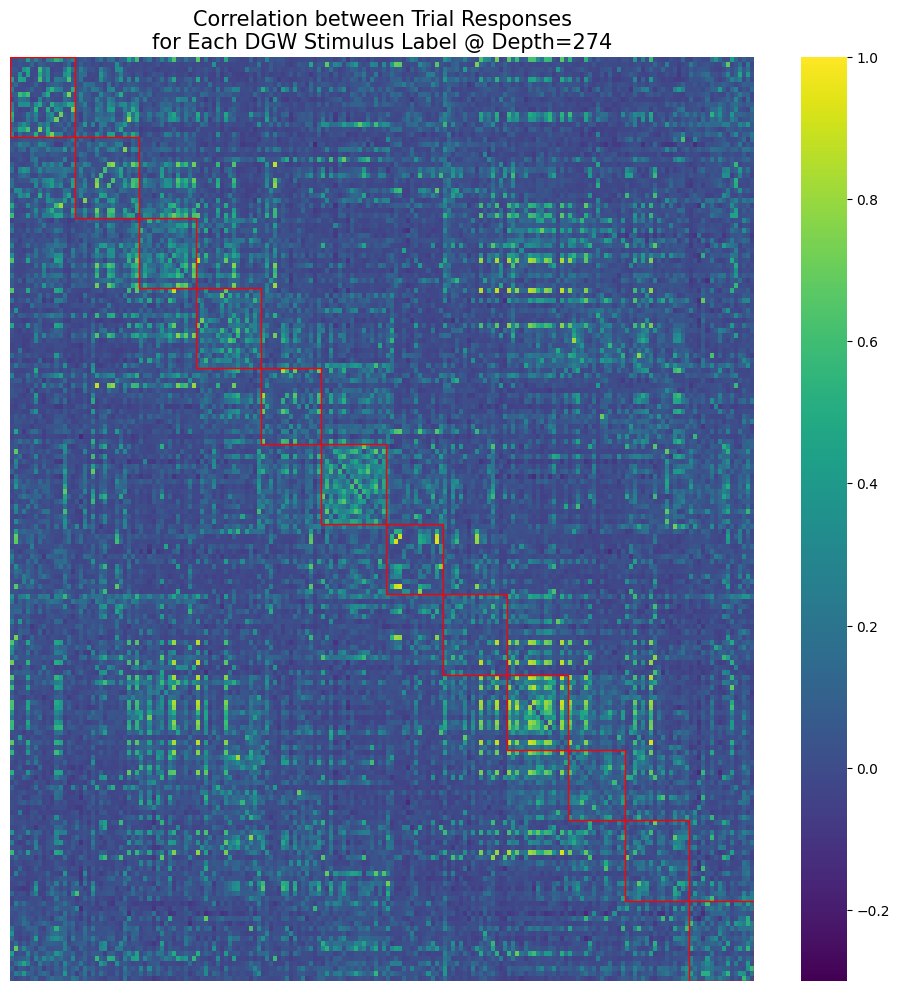

In [188]:
plt.figure(figsize=(12, 12))
depth = 274
# depth = 130

corrs_sample = all_corrs[np.array(depths) == depth][0]
corrs_sample[np.eye(corrs_sample.shape[0],dtype=bool)] = 0
sns.heatmap(corrs_sample, cmap='viridis', vmin=-0.3, vmax=1)
plt.title(f'Correlation between Trial Responses\nfor Each DGW Stimulus Label @ Depth={depth}', fontsize=15)
# plt.xticks(np.arange(0.5, len(sorted_y_data) + 0.5, 1), labels=sorted_y_data, rotation=90)
# plt.yticks(np.arange(0.5, len(sorted_y_data) + 0.5, 1), labels=sorted_y_data, rotation=0);

plt.xticks([])
plt.yticks([]);

# draw box around the trials where stimulus identites are the same
for i in np.unique(sorted_y_data):
    indices = np.where(sorted_y_data == i)[0]
    plt.gca().add_patch(plt.Rectangle((indices[0], indices[0]), len(indices), len(indices), fill=False, edgecolor='red', lw=1))

In [200]:
all_corrs = []
depths = []
mice = []

for sess_idx, sess_id in enumerate(client.get_all_session_ids()):
    try: 
        session = client.load_ophys_session(sess_id)
        print(sess_id)
    except:
        print(f"Could not load session {sess_id}")
        continue

    for plane in session.get_planes():
        try: 
            x_data = run_decoding.get_X_data(session, plane, "drifting_gratings_full") # T x N
            y_data = run_decoding.get_Y_data(session, plane, "drifting_gratings_full", "direction") # T x 1
            x_data_other = run_decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
            y_data_other = run_decoding.get_Y_data(session, plane, "drifting_gratings_windowed", "direction") # T x 1
        except:
            print(f"Could not get data for session {sess_id}")
            continue

        if x_data.shape[0] > 0 and x_data_other.shape[0] > 0:
            pass
        else:
            continue

        match = True
        if match:
            x_data = x_data[np.isin(y_data, y_data_other), :]
            y_data = y_data[np.isin(y_data, y_data_other)]

        x_data_means = np.zeros((np.unique(y_data).shape[0], x_data.shape[1]))
        x_data_other_means = np.zeros((np.unique(y_data_other).shape[0], x_data_other.shape[1]))
        corrs = np.zeros((np.unique(y_data).shape[0], np.unique(y_data_other).shape[0]))
        # corrs_self = np.zeros((np.unique(y_data).shape[0], np.unique(y_data).shape[0]))
        # corrs_other = np.zeros((np.unique(y_data_other).shape[0], np.unique(y_data_other).shape[0]))

        for i, label in enumerate(np.unique(y_data)):
            x_data_means[i] = x_data[y_data == label].mean(axis=0)

        for i, label in enumerate(np.unique(y_data_other)):
            x_data_other_means[i] = x_data_other[y_data_other == label].mean(axis=0)

        for i, label in enumerate(np.unique(y_data_other)):
            for j, label2 in enumerate(np.unique(y_data)):
                corrs[j, i] = np.corrcoef(x_data_means[j], x_data_other_means[i])[0, 1]
        
        all_corrs.append(corrs)
        depths.append(session.get_plane_depth(plane))
        mice.append(session.get_mouse_id())

all_corrs = np.array(all_corrs)

    #     for j, label2 in enumerate(np.unique(y_data)):
    #         corrs[j, i] = np.corrcoef(x_data_means[j], x_data_other_means[i])[0, 1]

    # for i, label in enumerate(np.unique(y_data)):
    #     for j, label2 in enumerate(np.unique(y_data)):
    #         corrs_self[j, i] = np.corrcoef(x_data_means[j], x_data_means[i])[0, 1]

    # for i, label in enumerate(np.unique(y_data_other)):
    #     for j, label2 in enumerate(np.unique(y_data_other)):
    #         corrs_other[j, i] = np.corrcoef(x_data_other_means[j], x_data_other_means[i])[0, 1]

M409828_11
Could not get data for session M409828_11
Could not get data for session M409828_11
Could not get data for session M409828_11
Could not get data for session M409828_11
Could not get data for session M409828_11
M409828_12
Could not get data for session M409828_12
Could not get data for session M409828_12
Could not get data for session M409828_12
Could not get data for session M409828_12
Could not get data for session M409828_12
M409828_13
Could not get data for session M409828_13
Could not get data for session M409828_13
Could not get data for session M409828_13
Could not get data for session M409828_13
Could not get data for session M409828_13
M409828_14
Could not get data for session M409828_14
Could not get data for session M409828_14
Could not get data for session M409828_14
Could not get data for session M409828_14
Could not get data for session M409828_14
M409828_15
Could not get data for session M409828_15
Could not get data for session M409828_15
Could not get data fo

/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


M427836_42
M427836_43
M427836_44
M427836_45
M427836_51
M427836_52
M427836_53
M427836_54
M427836_55
M438833_11
Could not get data for session M438833_11
Could not get data for session M438833_11
Could not get data for session M438833_11
Could not get data for session M438833_11
Could not get data for session M438833_11
M438833_12
Could not get data for session M438833_12
Could not get data for session M438833_12
Could not get data for session M438833_12
Could not get data for session M438833_12
Could not get data for session M438833_12
M438833_13
Could not get data for session M438833_13
Could not get data for session M438833_13
Could not get data for session M438833_13
Could not get data for session M438833_13
Could not get data for session M438833_13
M438833_14
Could not get data for session M438833_14
Could not get data for session M438833_14
Could not get data for session M438833_14
Could not get data for session M438833_14
Could not get data for session M438833_14
M438833_15
Could 

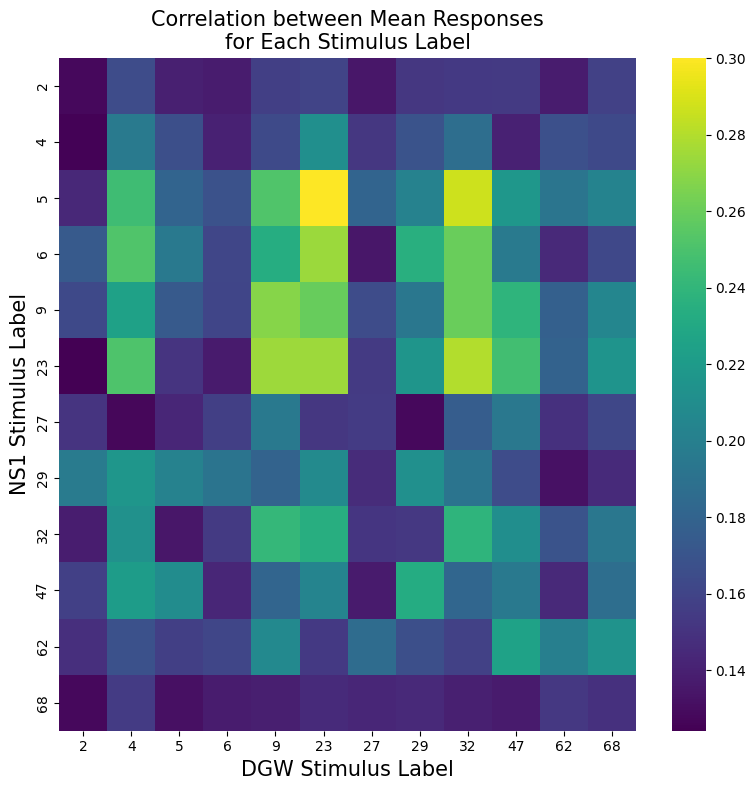

In [190]:
plt.figure(figsize=(8, 8))
sns.heatmap(np.nanmean(all_corrs, axis=0), cmap='viridis')
# plt.colorbar()
plt.xlabel('DGW Stimulus Label', fontsize=15)
plt.ylabel('NS1 Stimulus Label', fontsize=15)
plt.title('Correlation between Mean Responses\nfor Each Stimulus Label', fontsize=15)

plt.xticks(ticks=np.arange(0.5, 12), labels=np.unique(y_data_other))
plt.yticks(ticks=np.arange(0.5, len(np.unique(y_data))), labels=np.unique(y_data))

# draw box around diagonal
# for i in np.unique(y_data):
#     plt.gca().add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=2))

plt.tight_layout()

(0.0, 0.339512592342115)

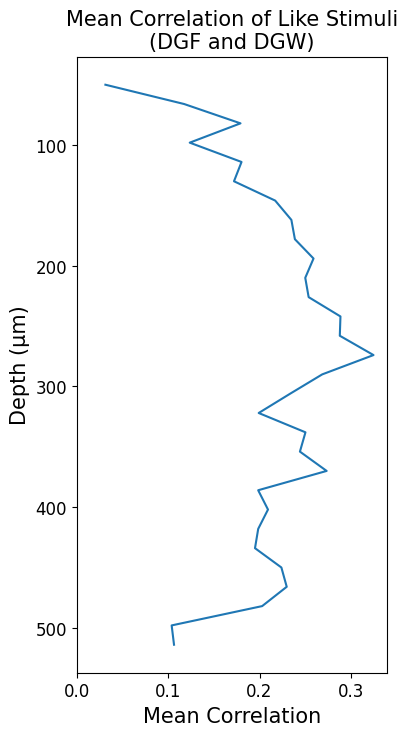

In [202]:
mean_corrs_like_stim = []
for depth in np.unique(depths):
    mean_corrs = np.nanmean(all_corrs[np.array(depths) == depth], axis=0)
    mean_corrs_like_stim.append(np.diag(mean_corrs).mean())

uniq_depths_arr = np.array(np.unique(depths))
plt.figure(figsize=(4, 8))
plt.plot(np.array(mean_corrs_like_stim)[(uniq_depths_arr < 515) & (uniq_depths_arr != 500)], uniq_depths_arr[(uniq_depths_arr < 515) & (uniq_depths_arr != 500)])
plt.gca().invert_yaxis()
plt.title('Mean Correlation of Like Stimuli\n(DGF and DGW)', fontsize=15)
plt.xlabel('Mean Correlation', fontsize=15)
plt.ylabel('Depth (µm)', fontsize=15)
plt.tick_params(axis="both", which="major", labelsize=12)

plt.xlim(left=0)

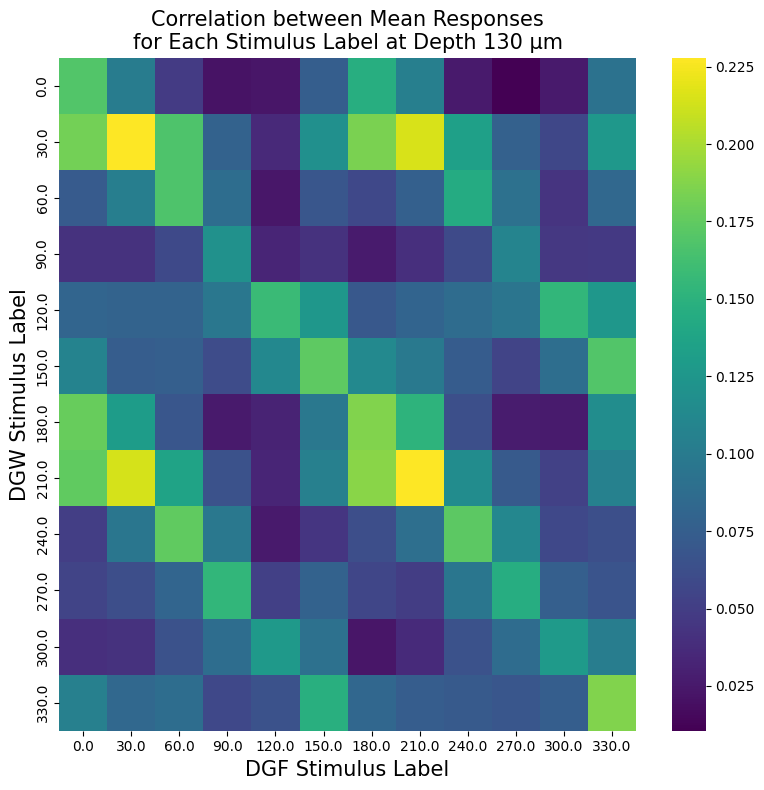

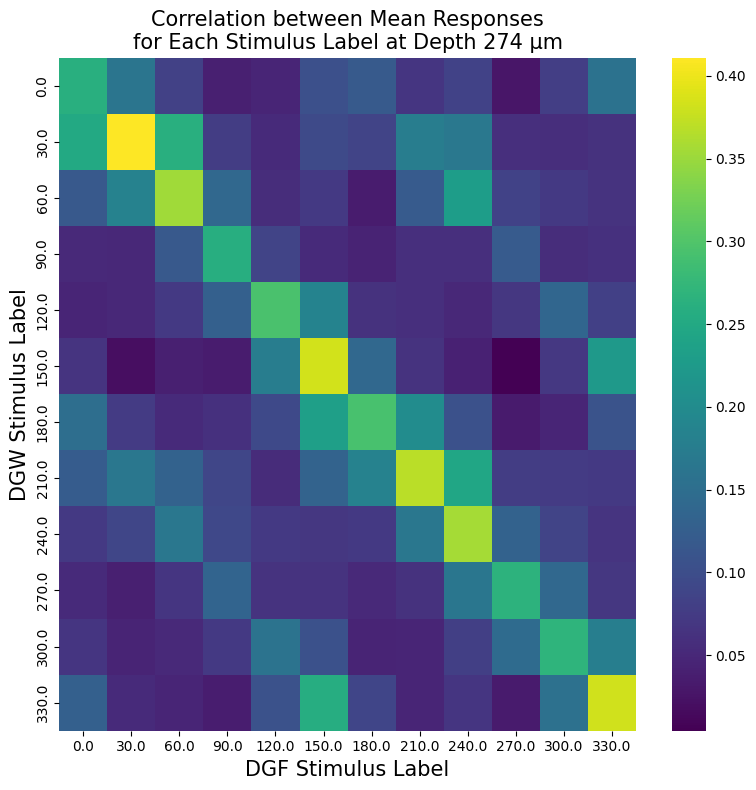

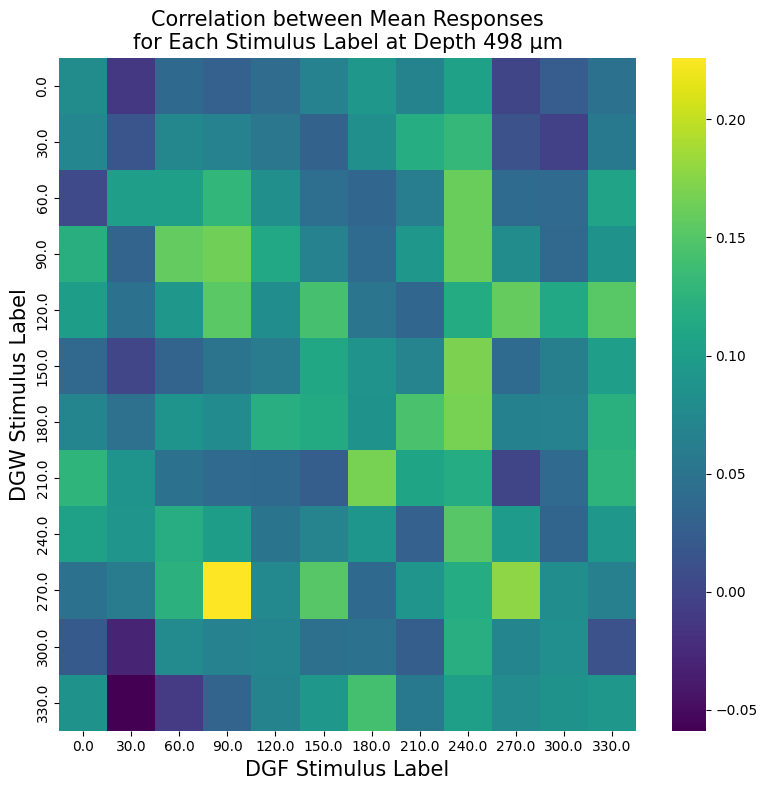

In [204]:
for depth in [130, 274, 498]:
    plt.figure(figsize=(8, 8))
    sns.heatmap(np.nanmean(all_corrs[np.array(depths) == depth], axis=0), cmap='viridis')
    # plt.colorbar()
    plt.xlabel('DGF Stimulus Label', fontsize=15)
    plt.ylabel('DGW Stimulus Label', fontsize=15)
    plt.title(f'Correlation between Mean Responses\nfor Each Stimulus Label at Depth {depth} µm', fontsize=15)

    plt.xticks(ticks=np.arange(0.5, 12), labels=np.unique(y_data_other))
    plt.yticks(ticks=np.arange(0.5, len(np.unique(y_data))), labels=np.unique(y_data))

    # draw box around diagonal
    # for i in np.unique(y_data):
    #     plt.gca().add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=2))

    plt.tight_layout()
    plt.show()

In [11]:
## Load in metrics
metrics_df = pd.read_csv('/home/naomi/Desktop/data/all_metrics_240426.csv')

df = run_decoding.run_decoding(
    session_id=session.get_session_id(),
    planes=[1],
    stimulus_type_training="natural_images",
    stimulus_type_testing="natural_images_12",
    repetitions=1,
    decode_dim="image_index",
    chunk_range=None,
    folds=5,
    bootstrap=False,
    bootstrap_size=1,
    metrics_df=metrics_df,
    tag="test_run",
    subset_test_data=False,
    save_decoding=False,
    match_trials=True, 
)

/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWar

In [12]:
df.test_accuracy.values

array([array([0.0875    , 0.08125   , 0.05833333, 0.09375   , 0.0875    ])],
      dtype=object)

### 3. if "time" or trial number is decodable from NS2

In [30]:
tag = "2025-09-17_1"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

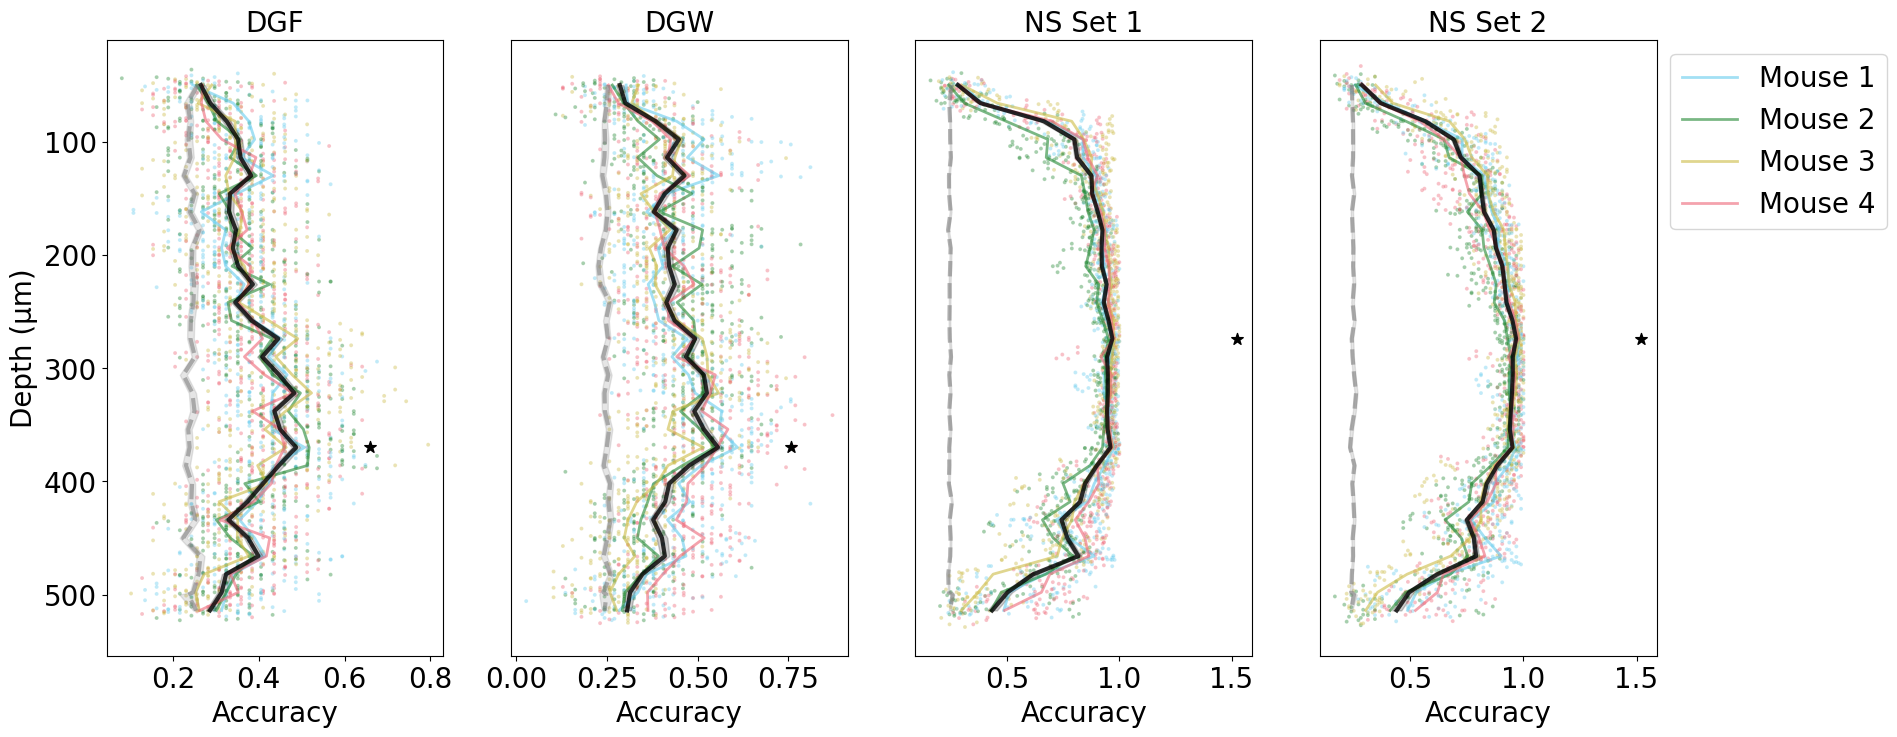

In [32]:
#### Plotting decoding accuracies for each mouse

# Some parameters for the plot
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}
n_stims = 4
jitter_amount = 5

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    temp_df = temp_df.explode('val_accuracy')
    # temp_df['val_accuracy'] = temp_df['val_accuracy'] / chance[stim_type]

    sns.lineplot(
        data=temp_df,
        x='val_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if stim_idx != 3 else True,
    )

    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == 3 else None

    sns.lineplot(data=temp_df, 
        x='val_accuracy', 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['val_accuracy'].mean().reset_index()
    sub_array = sub_df['val_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x='val_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        s=8,
        alpha=0.4,
        ax=ax,
        legend=False,
        zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_val_accuracy')
    # temp_df_shuf['shuf_val_accuracy'] = temp_df_shuf['shuf_val_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
        x='shuf_val_accuracy', 
        y='depth', 
        color='grey', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linestyle='--',
        linewidth=3, 
        alpha=0.6, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    ax.set_title(titles[stim_type], fontsize=fontsize)
    ax.set_xlabel('Accuracy', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    # ax.set_xlim(left=0, right=0.8) if stim_idx != 2 else ax.set_xlim(left=0, right=0.25)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

# plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2D_nobootstrapping_1plane_valaccuracies_decoding.svg'), dpi=300)

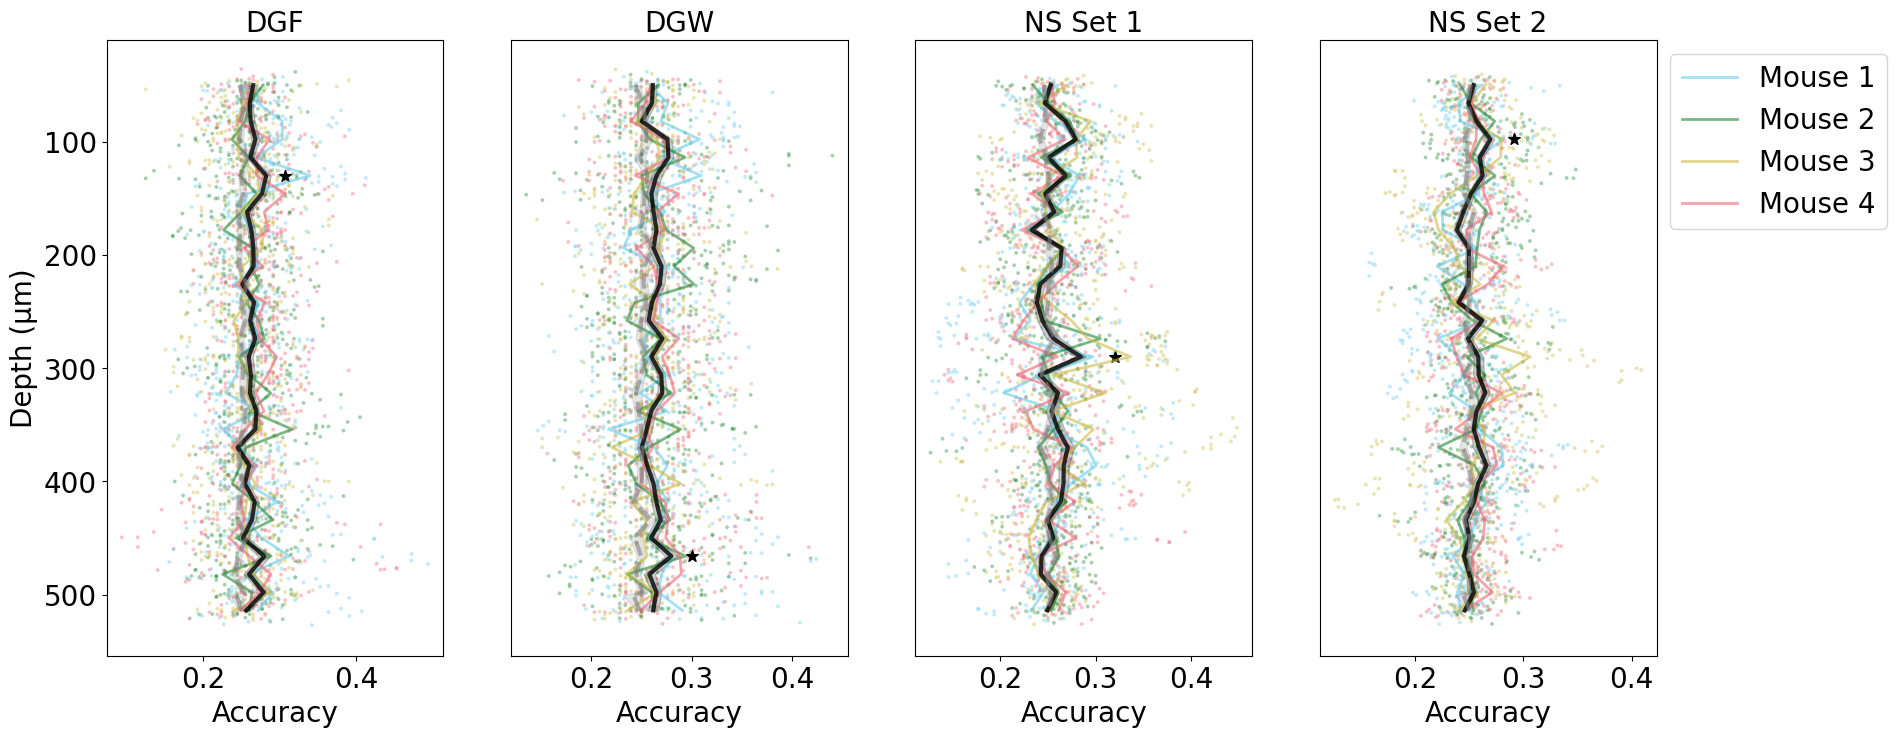

In [36]:
#### Plotting decoding accuracies for each mouse

# Some parameters for the plot
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}
n_stims = 4
jitter_amount = 5

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    temp_df = temp_df.explode('test_accuracy')
    # temp_df['test_accuracy'] = temp_df['test_accuracy'] / chance[stim_type]

    sns.lineplot(
        data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if stim_idx != 3 else True,
    )

    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == 3 else None

    sns.lineplot(data=temp_df, 
        x='test_accuracy', 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['test_accuracy'].mean().reset_index()
    sub_array = sub_df['test_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        s=8,
        alpha=0.4,
        ax=ax,
        legend=False,
        zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_test_accuracy')
    # temp_df_shuf['shuf_test_accuracy'] = temp_df_shuf['shuf_test_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
        x='shuf_test_accuracy', 
        y='depth', 
        color='grey', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linestyle='--',
        linewidth=3, 
        alpha=0.6, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    ax.set_title(titles[stim_type], fontsize=fontsize)
    ax.set_xlabel('Accuracy', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    # ax.set_xlim(left=0, right=0.8) if stim_idx != 2 else ax.set_xlim(left=0, right=0.25)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

# plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2D_nobootstrapping_1plane_valaccuracies_decoding.svg'), dpi=300)

In [33]:
import sys, os
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import run_decoding
from allen_v1dd.client import OPhysClient
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from v1dd_public import ARTIFACT_DIR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

In [34]:
# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '25'
plane = 6
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

# Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
x_data = run_decoding.get_X_data(session, plane, "drifting_gratings_full") # T x N
y_data = run_decoding.get_Y_data(session, plane, "drifting_gratings_full", 'time', 4) # T x 1

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Perform k-NN classification with hyperparameter tuning
param_grid = {'n_neighbors': list(range(1, 30))}
knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_k_HIGH = grid_search.best_params_['n_neighbors']

# Fit the best model
knn = KNeighborsClassifier(n_neighbors=best_k_HIGH, metric='correlation')
knn.fit(x_train, y_train)

# Predict on training and test data
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

# Calculate accuracy
print('HIGH PERFORMANCE EXAMPLE')
print(f"Training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")
print(f"Test accuracy: {metrics.accuracy_score(y_test, y_pred_test)}")

HIGH PERFORMANCE EXAMPLE
Training accuracy: 0.49019607843137253
Test accuracy: 0.15384615384615385


Text(0.5, 1.0, 'Confusion Matrix for Natural Images Decoding')

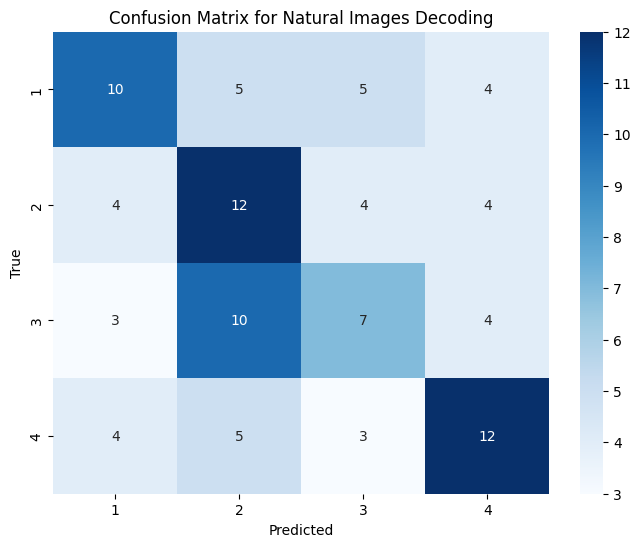

In [62]:
## confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, num_splits+1), yticklabels=range(1, num_splits+1))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Natural Images Decoding')